<h1>Simulation Based Inference (SBI)</h1>
<div class="text">
    <p>
    In this notebook I will explain how the sbi package which is extensively used in this project. 
    <br>
    This tutorial is based on the once that can be found on the sbi-dev webiste, but it will be applied to simulated data of the Epoch of Reionization (EoR). Tutorial 1 and 3 explain how to create coeval cubes and how to run multiple simulations.
    </p>
    <p>
        In Astrophysics, Bayesian Inference is useful for calculating the value of the paramters which influenced a certain observation. In more details, it is used to calculate the posterior $p(\theta|x)$, which is the probability distribution of the parameters $\theta$ given the observation x. 
        <br>
        The posterior can be calculated using Bayes theorem:
    </p>
    <p>
        <center>
        $p(\theta|x) \propto p(x|\theta)\cdot p(\theta)$,
    </p>
    <p> 
        where $p(x|\theta)$ is the likelihood and $p(\theta)$ is the prior. However, to use this equation, we would need to know the likelihood. The issue is that it is not always possible to know the right equation of the likelihood and approximations are often used. This is the case for intractable likelihoods, where the physical process is quite complicated to know the true likelihood.
        <br>
        This is where SBI is very useful, because it uses Neural Networks, in particular Neural Density Estimators (NDE) to learn the likelihood or the posterior directly (this is why SBI is often also called likelihood-free inference).
    </p>
    <p>
        Since the true likelihood is not known, the NDE will learn by minimizing the Kullback-Liebler (KL) divergence [Prelogovic 2023], which in turn means minimizing the loss functions:
    </p>
        <p>
            <center>
                \[L = -\frac{1}{N}\sum_{i=1}^{N}\log\mathcal{L}_{NN}(d_{PS,i}|\theta)\]
        </p>
    <p>
    </p>
</div>

In [1]:
import torch
from torch.optim import Adam
import sys
import os 

from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.neural_nets.net_builders import build_nsf

sys.path.insert(1, os.path.abspath('../')) # Note that this line is useless with a regular pip installation of PyWST.
import pietrosbi as psbi

/obs/pguidi/anaconda3/envs/sbi_21cmfast_env/lib/python3.9/site-packages/py21cmfast/_cfg.py:57: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/obs/pguidi/anaconda3/envs/sbi_21cmfast_env/lib/python3.9/site-packages/py21cmfast/_cfg.py:41: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [2]:
def simulator(theta):
    '''
    Simulator which is a linear gaussian

    Inputs:
        - theta: the set of paramters for the simulation

    Outputs:
        - The results of the simulator (same shape as theta)
    '''
    
    return theta + 1.0 + torch.randn_like(theta) * 0.1


In [3]:
# Number of dimensions (or number of paramters theta)
num_dim = 3

# Prior of the parameters p(\theta). In this case a uniform distribution
prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [4]:
# Number of simulations
num_simulations = 2000

# Generate random theta paramters
theta = prior.sample((num_simulations,))

# Create data with the simulator
x = simulator(theta)
print("theta.shape", theta.shape)
print("x.shape", x.shape)

# Generate an observation
theta_true = prior.sample((1,))
x_obs = simulator(theta_true)


theta.shape torch.Size([2000, 3])
x.shape torch.Size([2000, 3])


<h2>Default method to train the NDE</h2>

In [5]:
def create_posterior(theta, x, prior):
    '''
    It creates the Neural Posterior Estimator (NPE).
    It uses the data and parameters to train the the NPE 
    and create the posterior.

    Inputs:
        - theta: paramters of the simulations
        - x: data created by the simulator
        - prior: the prior of the parameters

    Output:
        - posterior: the learned posterior of the NPE
    '''

    # Create the NPE
    inference = NPE(prior=prior)

    # Append the simulations to the inference
    inference = inference.append_simulations(theta, x)

    # Training of the NPE
    density_estimator = inference.train()

    # Building the posterior
    posterior = inference.build_posterior(density_estimator)

    # Prints how the posterior was trained
    print(posterior) 

    return posterior

posterior = create_posterior(theta, x, prior)

 Neural network successfully converged after 100 epochs.Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

(<Figure size 600x600 with 9 Axes>,
 array([[<Axes: xlabel='$\\theta_1$'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='$\\theta_2$'>, <Axes: >],
        [<Axes: xlabel='$\\theta_1$'>, <Axes: xlabel='$\\theta_2$'>,
         <Axes: xlabel='$\\theta_3$'>]], dtype=object))

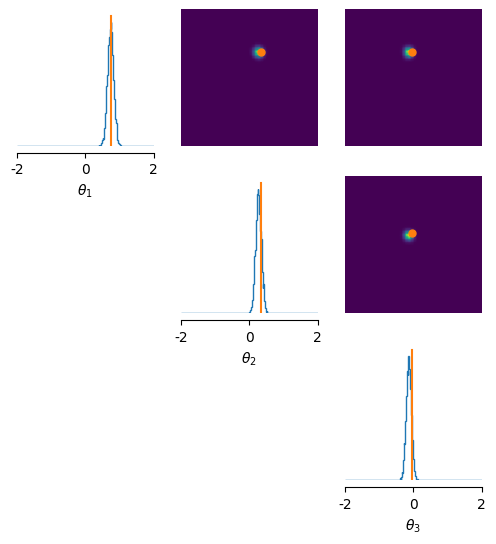

In [6]:
# Sampling from the posterior conditioned on the observed data x_obs
samples = posterior.sample((10000,), x=x_obs)

# Creates the cornerplot from the samples
pairplot(samples,
         points=theta_true,
         limits=[[-2, 2], [-2, 2], [-2, 2]],
         figsize=(6, 6),
         labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]
        )

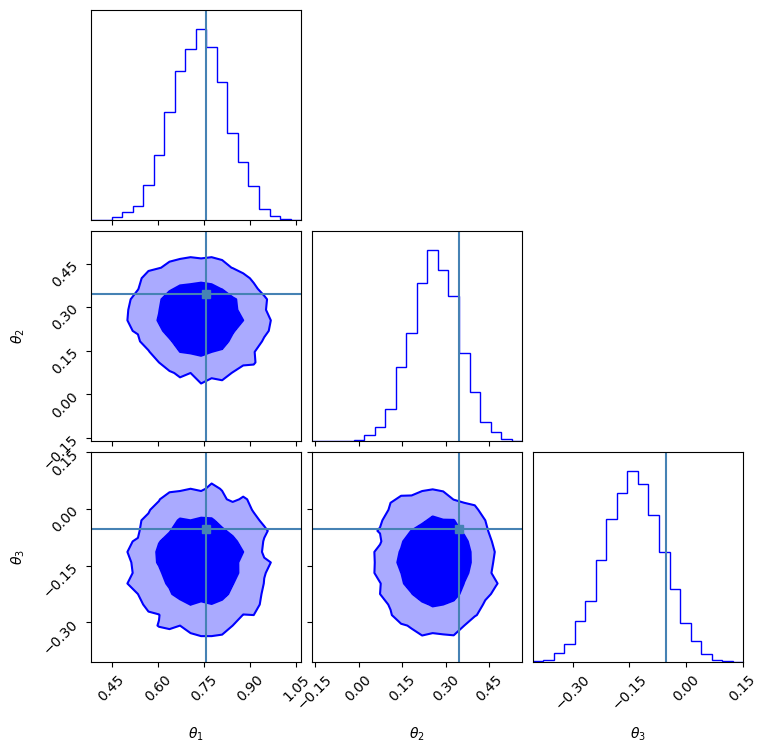

In [7]:
# My function for the cornerplot
# This can be found in /pietrosbi/posterior_corners.py
psbi.my_cornerplot(samples, 
                   truths = theta_true.flatten(), 
                   labels = [r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"], 
                   bins = 20, 
                   datapoints = False, 
                   smooth=False, 
                   limits=None
                  )

<h2>A more flexible denisty estimator</h2>
<div class="text">
    A similar code will be used for the training process on the 21cmfast simulations
</div>

In [8]:
# Create a NDE, which in this case in a Neural Spline Flaw (NSF)
density_estimator = build_nsf(theta, x)

# Choose an optimizer. In this case the Adam optimizer is used with learning rate = 5e-4
opt = Adam(list(density_estimator.parameters()), lr=5e-4)

# Number of epochs
epochs = 200

# Train the NSF with 200 epochs
for _ in range(epochs):
    opt.zero_grad()
    losses = density_estimator.loss(theta, condition=x)
    loss = torch.mean(losses)
    loss.backward()
    opt.step()

In [9]:
# Setting the value of a possible observation.
# We could use the simulator for this, so that we also have theta_true
#x_o = torch.as_tensor([[1.0, 1.0, 1.0]])
print(f"Shape of x_o: {x_obs.shape}            # Must have a batch dimension")

# Sampling from the posterior
samples = density_estimator.sample((10000,), condition=x_obs).detach()
print(f"Shape of samples: {samples.shape}  # Samples are returned with a batch dimension.")

# Reshaping the samples tensor
samples = samples.squeeze(dim=1)
print(f"Shape of samples: {samples.shape}     # Removed batch dimension.")

Shape of x_o: torch.Size([1, 3])            # Must have a batch dimension
Shape of samples: torch.Size([10000, 1, 3])  # Samples are returned with a batch dimension.
Shape of samples: torch.Size([10000, 3])     # Removed batch dimension.


/obs/pguidi/anaconda3/envs/sbi_21cmfast_env/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2190.)
  outputs, _ = torch.triangular_solve(


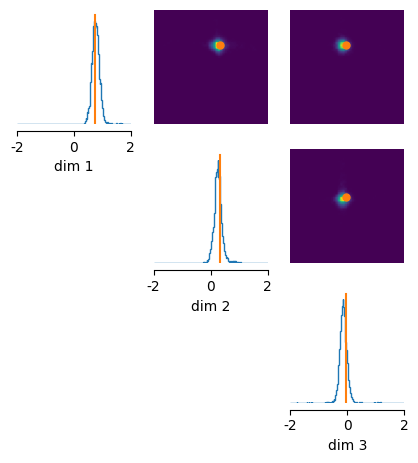

In [10]:
# Plotting the cornerplot of the posterior
pairplot(samples, points=theta_true, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5));

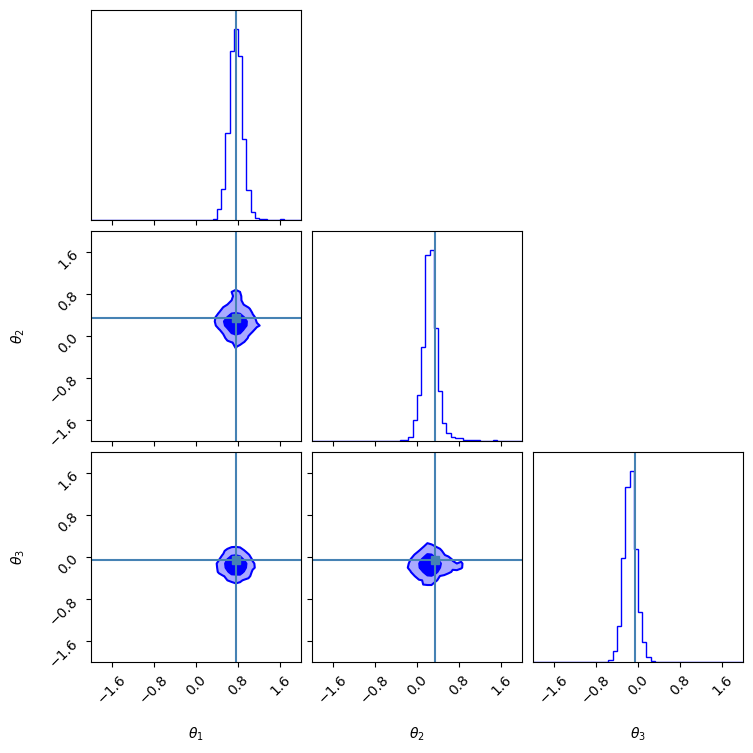

In [11]:
# My function for the cornerplot
# This can be found in /pietrosbi/posterior_corners.py
psbi.my_cornerplot(samples,  
                   truths = theta_true.flatten(),
                   labels = [r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"], 
                   bins = 50, 
                   datapoints = False, 
                   smooth=False, 
                   limits=[[-2, 2], [-2, 2], [-2, 2]]
                  )